# Softmax Classifier

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=3, suppress=True)

## Class Softmax

This is the implementation of the linear Softmax classifier:
* The Python class has two metods: `train(X, Y)` and `Y = predict(X)`.
* Matrix `self.W` is the weight matrix and also includes the bias vector ([bias tricks](https://cs231n.github.io/linear-classify/#interpreting-a-linear-classifier)).
* Training is done by using stochastic gradient descent method.

Let us define the score function as linear combination of all feature values.

$ F = X W$

$ \text{softmax}(i) = e^{F_{Y_{i}}} \Big/ \sum_{j=1}^C e^{F_{i}} $

$ L_{i}=-\log \left( \text{softmax}(i) \right) $

$ L=\underbrace{\frac{1}{N} \sum_{i=1}^N L_{i}}_{\text {data loss }}+\underbrace{\lambda R(W)}_{\text {regularization loss }} $

$ R(W) = \sum_{k=1}^C \sum_{l=1}^{D+1} W_{l, k}^{2} $

where:
- the dataset contains $N$ samples of data
- each sample has $D$ features (dimensionalities) and $C$ labels/classes (distinct categories)
- $X \in \mathbb{R}^{N \times (D+1)}$ contains the features from N samples of data
- $X_i \in \mathbb{R}^{D+1}$ contains the features of the $i$-th sample ($i$-th row of $X$)
- $Y \in \mathbb{R}^{N}$ contains the labels from N samples of data
- $Y_i \in \mathbb{R}$ contains the label of the $i$-th sample ($i$-th row of $Y$)
- $F_i \in \mathbb{R}^{C}$ is the scores for all classes of $i$-th sample
- $F_{y_i} \in \mathbb{R}$ is the score for the correct class of $i$-th sample
- $L \in \mathbb{R}$ is the total loss
- $L_i \in \mathbb{R}$ is the loss of $i$-th sample
- $W \in \mathbb{R}^{(D+1) \times C}$ is the weight matrix (with augmented bias vector in the last row)
- $R \in \mathbb{R}$ is the regularization loss

In [8]:
from numba import njit, prange

class Softmax():
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def softmax_loss(W, X, Y, reg):
        """
        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D+1, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - Y: A numpy array of shape (N,) containing training labels; Y[i] = c means
          that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss: loss as single float
        - dW: gradient with respect to weights W; an array of same shape as W

        References:
        - https://github.com/lightaime/cs231n
        - https://github.com/mantasu/cs231n
        - https://github.com/jariasf/CS231n
        
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW   = np.zeros_like(W)
        
        N = X.shape[0] # samples 
        C = W.shape[1] # classes
        X = np.hstack((X, np.ones((N, 1)))) # the last column is 1: to allow augmentation of bias vector into W

        F = X@W 

        # Softmax Loss
        for i in prange(N):
            Fi = F[i] - np.max(F[i])
            expFi = np.exp(Fi)
            softmax = expFi/np.sum(expFi) 
            loss += -np.log(softmax[Y[i]])

            # Weight Gradients
            for j in prange(C):
                dW[:, j] += X[i] * softmax[j]
            dW[:, Y[i]] -= X[i]

        # Average
        loss /= N
        dW /= N

        # Regularization
        loss += reg * np.sum(W * W)
        dW += reg * 2 * W 

        return loss, dW
 

    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True):
        '''
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - Y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        N, D = X.shape
        C = len(np.unique(Y)) 
        
        # lazily initialize W
        self.W = 0.001 * np.random.randn(D+1, C) # dim+1, to bias vector is augmented into W 

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            batch_indices = np.random.choice(N, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = Y[batch_indices]
            
            # evaluate loss and gradient
            loss, grad = self.softmax_loss(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % 5000 == 0:
                print('iteration', it, 'of', num_iters, 'loss', loss, flush=True)

        return loss_history
    

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - Y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        X  = np.hstack((X, np.ones((X.shape[0],1))))

        Y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        Y_pred = scores.argmax(axis=1)

        return Y_pred

## Breast Cancer Wisconsin

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

[This dataset is also available as one of scikit-learn example datasets](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
).

The original labels are characters: `M` and `B`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `M` is replaced with `1`
* `B` is replaced with `0`

### Load the Dataset

In [9]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
Y = np.zeros(X.shape[0], dtype=np.int32) 
Y[np.where(data[:,1]=='M')] = 1
Y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(Y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


### Split The Dataset for Training and Test

In [10]:
X_train = X[0:400, :]
Y_train = Y[0:400]
X_test  = X[401:, :]
y_test  = Y[401:]

num_test = X_test.shape[0]

### Train the Classifier

In [11]:
classifier = Softmax()
loss_hist = classifier.train(X_train, Y_train, learning_rate=1e-6,batch_size=200, reg=0.1, num_iters=50000)

iteration 0 of 50000 loss 0.7410744252582849
iteration 5000 of 50000 loss 0.4714239182708896
iteration 10000 of 50000 loss 0.4236168575470019
iteration 15000 of 50000 loss 0.4069955930724648
iteration 20000 of 50000 loss 0.3745121687227387
iteration 25000 of 50000 loss 0.3874151470925481
iteration 30000 of 50000 loss 0.40471936349688864
iteration 35000 of 50000 loss 0.3940060223427648
iteration 40000 of 50000 loss 0.3882917481160629
iteration 45000 of 50000 loss 0.3497352674595324


### Plot the Loss

Plot the loss as a function of iteration number.

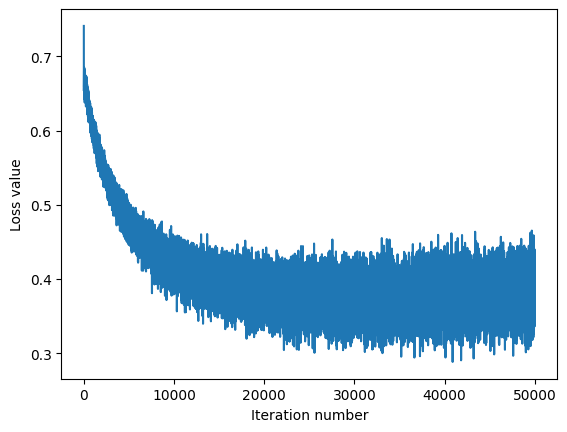

In [12]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier
Evaluate the performance on both the training and validation set.

In [13]:
Y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == Y_train_pred), ))
Y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == Y_test_pred), ))

training accuracy: 0.847500
validation accuracy: 0.886905


## Handwritten Digits

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

### Training Data

In [14]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tra", delimiter=",", dtype=int)
X_train = np.int32(data[:, 0:-1])  
Y_train = np.int32(data[:, -1]) 

print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(Y_train))

Dimension numbers : 64
Number of data    : 3823
Labels            : [0 1 2 3 4 5 6 7 8 9]


### Test Data

In [15]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tes", delimiter=",", dtype=int)
X_test = np.int32(data[:, 0:-1])  
Y_test = np.int32(data[:, -1]) 

print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(Y_test))

Dimension numbers : 64
Number of data    : 1797
Labels            : [0 1 2 3 4 5 6 7 8 9]


### Train the Classifier

In [16]:
classifier = Softmax()
loss_hist = classifier.train(X_train, Y_train, learning_rate=1e-4,batch_size=500, num_iters=50000)

iteration 0 of 50000 loss 2.3113339690427086
iteration 5000 of 50000 loss 0.24013016807748774
iteration 10000 of 50000 loss 0.17219982527152627
iteration 15000 of 50000 loss 0.1673990217521423
iteration 20000 of 50000 loss 0.11902285506459935
iteration 25000 of 50000 loss 0.11417391990645162
iteration 30000 of 50000 loss 0.11249768758326993
iteration 35000 of 50000 loss 0.1499958547689556
iteration 40000 of 50000 loss 0.1263878475202249
iteration 45000 of 50000 loss 0.08895489103288332


### Plot the Loss

Plot the loss as a function of iteration number.

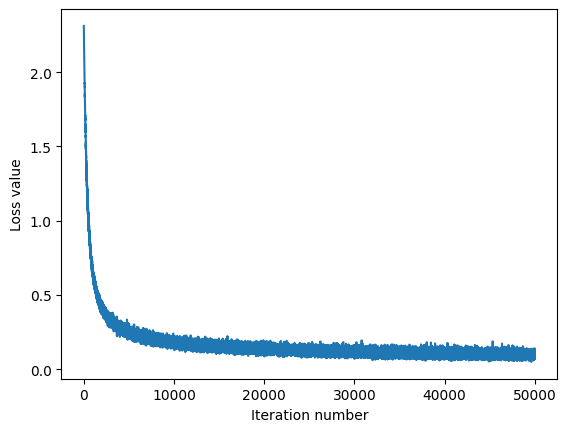

In [17]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Test the Classifier

Evaluate the performance on both the training and validation set.

In [18]:
Y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == Y_train_pred), ))
Y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(Y_test == Y_test_pred), ))

training accuracy: 0.973319
validation accuracy: 0.942682


### Visualize the Learned Weights
* Take matrix `W` and strip out the bias. 
* For each class, reshape the matrix back into 2D arrays
* Plot the 2D arrays (matrices) as images.

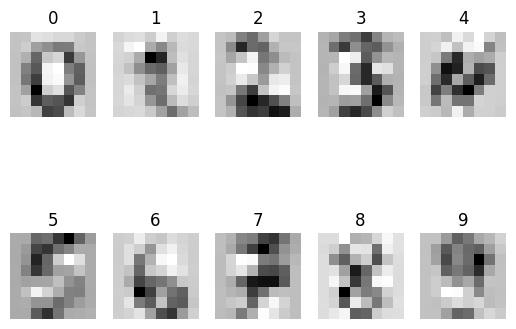

In [19]:
w = classifier.W[:-1, :] # strip out the bias
w = w.reshape(8, 8, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), cmap='Greys')
    plt.axis('off')
    plt.title(classes[i])